# Question 7: RNN - LSTM - NLP (1.0 điểm)
- Use Clothing, Shoes and Jewelry dataset (file Clothing_Shoes_and_Jewelry_5.json in reviews_Clothing_Shoes_and_Jewelry_5.json.gz) to build a model to predict customer sentiment (You can categories into 3 groups such as like: 4 or 5 stars, dislike: 1 or 2 stars, neutral :3 stars; or categories into 2 groups...) (**overall** column) based on their review (**reviewText** column)
- Read more information here: http://jmcauley.ucsd.edu/data/amazon/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Conv1D,MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung


In [ ]:
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [ ]:
import glob
import json
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
dir_data = 'data/Dataset/reviews_Clothing_Shoes_and_Jewelry_5.json.gz'
data = getDF(dir_data)

In [ ]:
data

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"
...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5.0,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5.0,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5.0,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5.0,Holds Up Well In Real World Test,1404691200,"07 7, 2014"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      278677 non-null  object 
 1   asin            278677 non-null  object 
 2   reviewerName    278225 non-null  object 
 3   helpful         278677 non-null  object 
 4   reviewText      278677 non-null  object 
 5   overall         278677 non-null  float64
 6   summary         278677 non-null  object 
 7   unixReviewTime  278677 non-null  int64  
 8   reviewTime      278677 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 21.3+ MB


In [ ]:
data.describe()

,overall,unixReviewTime
count,278677.000000,2.786770e+05
mean,4.245133,1.374197e+09
std,1.103747,2.904510e+07
min,1.000000,1.048896e+09
25%,4.000000,1.362787e+09
50%,5.000000,1.382141e+09
75%,5.000000,1.393200e+09
max,5.000000,1.406074e+09


In [ ]:
data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [ ]:
data['words'] = data['reviewText'].map(lambda x: len(x.split()))
data['words_summary'] = data['summary'].map(lambda x: len(x.split()))
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,words,words_summary
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011",35,5
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013",61,2
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013",62,6
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014",76,2
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014",80,4


In [ ]:
data[['words', 'words_summary']].describe()


,words,words_summary
count,278677.000000,278677.000000
mean,59.953046,3.670899
std,61.289861,2.572253
min,0.000000,1.000000
25%,26.000000,2.000000
50%,41.000000,3.000000
75%,70.000000,5.000000
max,3882.000000,31.000000


In [ ]:
data[['overall','words']].groupby("overall").mean("words")


,words
overall,
1.0,63.988295
2.0,65.800750
3.0,64.584552
4.0,65.105026
5.0,56.417434


In [ ]:
def categorical_univariate_variable(f):
    print('1\ Số giá trị unique: ', f.nunique())
    print("2\ Mật độ phân phối: \n", f.value_counts())
    print("3\ Số giá trị NaN: \n", f.isnull().sum())
    print("\n\n4\ Tỉ lệ mật độ phân phối:\n", f.value_counts() / len(f))
    sns.countplot(f)
    plt.show() 

Overall
1\ Số giá trị unique:  5
2\ Mật độ phân phối: 
 5.0    163240
4.0     58357
3.0     30425
2.0     15463
1.0     11192
Name: overall, dtype: int64
3\ Số giá trị NaN: 
 0


4\ Tỉ lệ mật độ phân phối:
 5.0    0.585768
4.0    0.209407
3.0    0.109177
2.0    0.055487
1.0    0.040161
Name: overall, dtype: float64


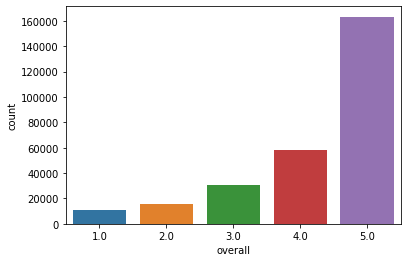

In [ ]:
print('Overall')
categorical_univariate_variable(data.overall)

overall bị mất cân bằng, nhóm 5 chiếm đa số còn nhóm 1, 2, 3 khá thấp

In [ ]:
def split_overall(x):
    if x == 1. or x == 2. or x == 3. or x == 4.:
        return 0 #  'unsatisfied'
    else:
        return 1 # 'pleasure'

In [ ]:
data['status'] = data['overall'].map(lambda x: split_overall(x))


Status
1\ Số giá trị unique:  2
2\ Mật độ phân phối: 
 1    163240
0    115437
Name: status, dtype: int64
3\ Số giá trị NaN: 
 0


4\ Tỉ lệ mật độ phân phối:
 1    0.585768
0    0.414232
Name: status, dtype: float64


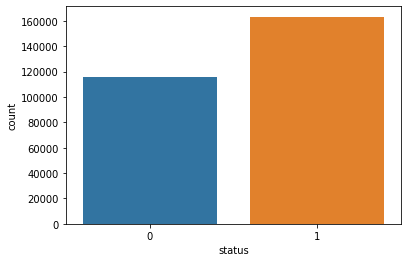

In [ ]:
print('Status')
categorical_univariate_variable(data.status)

sau khi gom lại thành 2 nhóm: 0 là unsatisfied, 1 là pleasure:
dù 2 nhóm vẫn hơi lệch (nhóm 0 chiếm ~ 41%, nhóm 1 chiếm ~ 58%),
Tuy nhiên, độ lệch này ko bị quá cao, ta cứ thử build model trước, nếu model cho kết quả tệ thì ta sẽ áp dụng oversampling hoặc undersampling để xử lý phần data bị mất cân bằng này

### **Split data**

In [ ]:
data_new = data[['reviewText', 'summary', 'words', 'words_summary','status']].copy()
data_new.head()

,reviewText,summary,words,words_summary,status
0,This is a great tutu and at a really great pri...,Great tutu- not cheaply made,35,5,1
1,I bought this for my 4 yr old daughter for dan...,Very Cute!!,61,2,1
2,What can I say... my daughters have it in oran...,I have buy more than one,62,6,1
3,"We bought several tutus at once, and they are ...","Adorable, Sturdy",76,2,1
4,Thank you Halo Heaven great product for Little...,Grammy's Angels Love it,80,4,1


In [ ]:
X = data_new['reviewText']
Y = data_new['status']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3, random_state=42)

### **Feature Enginnering**

In [ ]:
# max_words = data_new.words_summary.max()
max_words = 2000
max_len=300

In [ ]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

In [ ]:
print(sequences[:5])

[[24, 115, 18, 15, 79, 132, 6, 144, 32, 190, 26, 4, 137, 10, 7, 47, 28, 4, 139, 3, 251, 374, 2, 61, 1365, 69, 29, 321], [502, 257, 190, 6, 300, 15, 6, 275, 5, 80, 1, 1504, 87, 140, 55, 1, 76, 676, 798, 278, 6, 18, 3, 6, 275, 28, 6, 44, 107, 8, 12, 608], [725, 4, 29, 248, 272, 3, 2, 77, 4, 110, 557, 5, 277, 159, 25, 89, 6, 467, 24, 73, 1, 348, 1002, 7, 18, 1, 1430, 3, 147, 20, 4, 967, 30, 80, 20, 105, 10, 315, 5, 419, 537, 4, 59, 47, 3, 63, 4, 140, 71, 315, 21, 47, 1496, 1809, 1847], [132, 43, 73, 369, 681, 246, 1, 104, 1851, 3, 25, 46, 50, 5, 641, 175, 3, 32, 368, 5, 517, 12, 1305, 50, 447, 9, 1525, 1, 122, 1, 230, 1, 58, 9, 1, 525, 66, 193, 612, 1132, 1364, 2, 148, 323, 456, 170, 25, 23, 180, 60, 447, 9, 16, 281, 636, 3, 640, 5, 88, 180, 1642, 5, 1976, 180, 97, 389, 4, 805, 597, 256, 180, 393, 5, 5, 172, 148, 6, 584, 3, 6, 25, 4, 37, 251, 180, 135, 1860, 968, 5, 3, 104, 17, 6, 482, 107, 180, 56, 5, 1, 3, 125, 104, 5, 456, 106, 802, 1045, 29, 170, 93, 180, 707, 50, 1394, 1525, 1, 131, 

In [ ]:
# sequences_matrix[:2]

### **Build model**

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 50))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',  
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          100000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

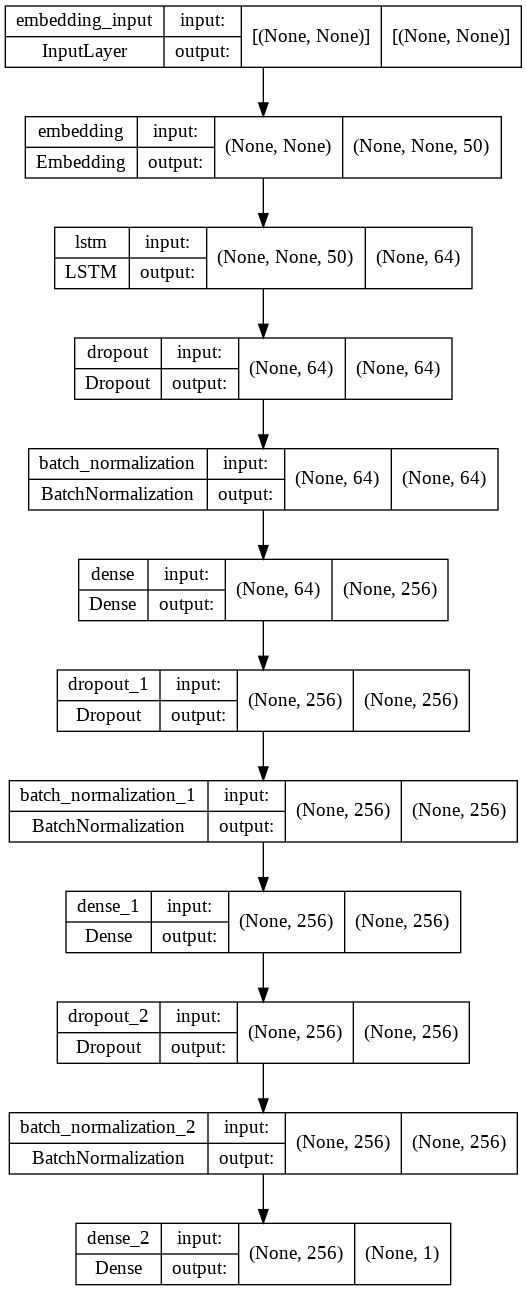

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=True)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                      min_delta=0.00001, 
                      patience=25, #20 
                      verbose=1, 
                      mode='auto', 
                      restore_best_weights=True)    
# learning_rate = ReduceLROnPlateau(verbose=1,factor=0.5,min_delta=0.00001,patience=30)

In [ ]:
history = model.fit(sequences_matrix, Y_train,
                    batch_size=256,
                    epochs=300,
                    validation_split=0.2, # cross validation
                    callbacks=[early_stopping])

Epoch 1/300
610/610 [==============================] - 24s 27ms/step - loss: 0.5018 - accuracy: 0.7678 - val_loss: 0.4604 - val_accuracy: 0.7915
Epoch 2/300
610/610 [==============================] - 16s 26ms/step - loss: 0.4474 - accuracy: 0.7996 - val_loss: 0.4405 - val_accuracy: 0.8037
Epoch 3/300
610/610 [==============================] - 16s 26ms/step - loss: 0.4309 - accuracy: 0.8068 - val_loss: 0.4451 - val_accuracy: 0.7998
Epoch 4/300
610/610 [==============================] - 16s 26ms/step - loss: 0.4138 - accuracy: 0.8168 - val_loss: 0.4248 - val_accuracy: 0.8104
Epoch 5/300
610/610 [==============================] - 16s 26ms/step - loss: 0.3985 - accuracy: 0.8248 - val_loss: 0.4123 - val_accuracy: 0.8195
Epoch 6/300
610/610 [==============================] - 16s 26ms/step - loss: 0.3877 - accuracy: 0.8307 - val_loss: 0.4236 - val_accuracy: 0.8159
Epoch 7/300
610/610 [==============================] - 16s 26ms/step - loss: 0.3788 - accuracy: 0.8355 - val_loss: 0.4119 - val_ac

### **Evaluation**

In [ ]:
# test: text to sequence
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

2613/2613 [==============================] - 16s 6ms/step - loss: 0.4082 - accuracy: 0.8209


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.408
  Accuracy: 0.821


với train acc ~ 0.9, test acc = 0.82 => model ko có score cao lắm, có khả năng là do model bị mất cân bằng dữ liệu

### **Under Sampling**
- Cải thiện model bằng cách xử lý dữ liệu mất cân bằng

In [ ]:
df_status_1 = data_new[data_new.status == 1]
df_status_0 = data_new[data_new.status == 0]

In [ ]:
data_new.status.value_counts()

1    163240
0    115437
Name: status, dtype: int64

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
remove_n = 163240 - 115437
drop_indices = np.random.choice(df_status_1.index, remove_n, replace=False)
df_status_1_new = df_status_1.drop(drop_indices)

In [ ]:
df_new_2 = df_status_1_new.append(df_status_0, ignore_index=True)

In [ ]:
df_new_2

,reviewText,summary,words,words_summary,status
0,This is a great tutu and at a really great pri...,Great tutu- not cheaply made,35,5,1
1,"We bought several tutus at once, and they are ...","Adorable, Sturdy",76,2,1
2,Thank you Halo Heaven great product for Little...,Grammy's Angels Love it,80,4,1
3,Great tutu for a great price. It isn't a &#34;...,Great value,29,2,1
4,For what I paid for two tutus is unbeatable an...,WOW !! ..is all I have to say!,100,8,1
...,...,...,...,...,...
230869,Arrived with what looked like a bleach stain o...,Stained,43,1,0
230870,Trying to decide if return or just give away t...,just too small,22,3,0
230871,I go walking a lot in all kinds of weather and...,Great for Winter or Chilly Walks,94,6,0
230872,"Nice material, but not as nice as silk or mer...",Lightweight & useful,102,3,0


In [ ]:
df_new_2.status.value_counts()

1    115437
0    115437
Name: status, dtype: int64

In [ ]:
X_u = df_new_2['reviewText']
Y_u = df_new_2['status']

X_u_train, X_u_test, Y_u_train, Y_u_test = train_test_split(X_u, Y_u, test_size=0.3, random_state=42)

In [ ]:
# max_words = data_new.words_summary.max()
max_words = 2000
max_len=300

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_u_train)

sequences = tok.texts_to_sequences(X_u_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

### **Build Model**
- build lại model với dataset đã dc under sampling

In [ ]:
model2 = Sequential()
model2.add(Embedding(max_words, 50))
model2.add(LSTM(64))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',  
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          100000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

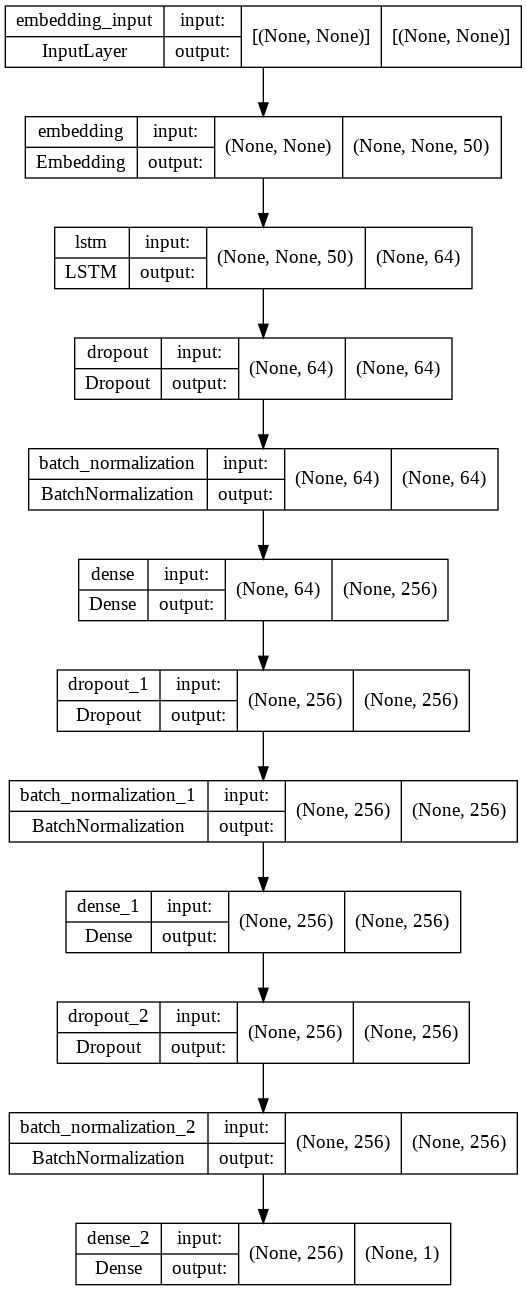

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model2, show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                      min_delta=0.00001, 
                      patience=25, #20 
                      verbose=1, 
                      mode='auto', 
                      restore_best_weights=True)    
# learning_rate = ReduceLROnPlateau(verbose=1,factor=0.5,min_delta=0.00001,patience=30)

In [ ]:
history = model2.fit(sequences_matrix, Y_u_train,
                    batch_size=256,
                    epochs=300,
                    validation_split=0.2, # cross validation
                    callbacks=[early_stopping])

Epoch 1/300
506/506 [==============================] - 25s 31ms/step - loss: 0.5264 - accuracy: 0.7501 - val_loss: 0.5011 - val_accuracy: 0.7845
Epoch 2/300
506/506 [==============================] - 15s 30ms/step - loss: 0.4599 - accuracy: 0.7910 - val_loss: 0.4634 - val_accuracy: 0.7868
Epoch 3/300
506/506 [==============================] - 15s 30ms/step - loss: 0.4484 - accuracy: 0.7955 - val_loss: 0.4573 - val_accuracy: 0.7868
Epoch 4/300
506/506 [==============================] - 15s 29ms/step - loss: 0.4351 - accuracy: 0.8026 - val_loss: 0.4422 - val_accuracy: 0.7983
Epoch 5/300
506/506 [==============================] - 15s 30ms/step - loss: 0.4197 - accuracy: 0.8097 - val_loss: 0.4543 - val_accuracy: 0.7913
Epoch 6/300
506/506 [==============================] - 15s 29ms/step - loss: 0.4078 - accuracy: 0.8169 - val_loss: 0.4437 - val_accuracy: 0.8043
Epoch 7/300
506/506 [==============================] - 15s 30ms/step - loss: 0.3984 - accuracy: 0.8215 - val_loss: 0.4388 - val_ac

### **Evaluation**

In [ ]:
# test: text to sequence
test_sequences = tok.texts_to_sequences(X_u_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
accr = model2.evaluate(test_sequences_matrix,Y_u_test)

2165/2165 [==============================] - 16s 7ms/step - loss: 0.4333 - accuracy: 0.8060


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.433
  Accuracy: 0.806


In [ ]:
'''
Có vẻ sau khi under sampling, kết quả cũng ko dc cải thiện
=> có thể cân nhắc đi rộng và sâu hơn cho LSTM
=> cân nhắc sử dụng feature summary thay vì reviewText cho phần text
=> có thể sử dụng nhiều features hơn để kết quả tốt hơn.
...
'''

'\nCó vẻ sau khi under sampling, kết quả cũng ko dc cải thiện\n=> có thể cân nhắc đi rộng và sâu hơn cho LSTM\n=> cân nhắc sử dụng feature summary thay vì reviewText cho phần text\n=> có thể sử dụng nhiều features hơn để kết quả tốt hơn.\n...\n'

#### **Save model**

In [ ]:
#Save the result
from tensorflow.keras.models import load_model
# Creates a HDF5 file 'my_model.h5'
model2.save('LDS8_K275_DinhVietTrung_Cuoi_ky/model/LSTM_NLPmodel_under_sampling.h5')

In [ ]:
X_new = pd.Series(data = ["Its good, i relly love it", "Bad service, disappoited"])
test_sequences_new = tok.texts_to_sequences(X_new)
test_sequences_matrix_new = sequence.pad_sequences(test_sequences_new,maxlen=max_len)

In [ ]:
test_sequences_matrix_new

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
# prediction
p = model.predict(test_sequences_matrix_new)
p = p >=0.5
p

array([[ True],
       [False]])

- True là thuộc nhóm 1: pleasure
- False là thuộc nhóm 0: unsatisfied
- Vì nhóm 0 và 1 là em tự đặt, ko dùng label encoder nên ko theo thứ tự alpha beta (vì vậy nhìn có vẻ hơi ngược:))